# A. Modeling Modules

The tutorial model is a very simple simulated agent-based economy, drawn from econophysics and presenting a statistical mechanics approach to wealth distribution [Dragulescu2002]. The rules of our tutorial model:

There are some number of agents.

All agents begin with 1 unit of money.

At every step of the model, an agent gives 1 unit of money (if they have it) to some other agent.

Despite its simplicity, this model yields results that are often unexpected to those not familiar with it. For our purposes, it also easily demonstrates Mesa’s core features.

### 1. Create Model class and Agent class

To begin writing the model code, we start with two core classes: one for the overall model, the other for the agents. The model class holds the model-level attributes, manages the agents, and generally handles the global level of our model. Each instantiation of the model class will be a specific model run. Each model will contain multiple agents, all of which are instantiations of the agent class. Both the model and agent classes are child classes of Mesa’s generic Model and Agent classes.

Each agent has only one variable: how much wealth it currently has. (Each agent will also have a unique identifier (i.e., a name), stored in the unique_id variable. Giving each agent a unique id is a good practice when doing agent-based modeling.)

There is only one model-level parameter: how many agents the model contains. When a new model is started, we want it to populate itself with the given number of agents.

In [1]:
from mesa import Agent, Model

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

### 2. Add a scheduler in model class

Time in most agent-based models moves in steps, sometimes also called ticks. At each step of the model, one or more of the agents – usually all of them – are activated and take their own step, changing internally and/or interacting with one another or the environment.

The scheduler is a special model component which controls the order in which agents are activated. For example, all the agents may activate in the same order every step; their order might be shuffled; we may try to simulate all the agents acting at the same time; and more. Mesa offers a few different built-in scheduler classes, with a common interface. That makes it easy to change the activation regime a given model uses, and see whether it changes the model behavior. This may not seem important, but scheduling patterns can have an impact on your results [Comer2014].

For now, let’s use one of the simplest ones: RandomActivation, which activates all the agents once per step, in random order. Every agent is expected to have a step method. The step method is the action the agent takes when it is activated by the model schedule. We add an agent to the schedule using the add method; when we call the schedule’s step method, the model shuffles the order of the agents, then activates and executes each agent’s step method.

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print ("Hi, I am agent " + str(self.unique_id) +".")

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

### 3. Create an object of the model and run it for one step

In [3]:
empty_model = MoneyModel(10)
empty_model.step()

Hi, I am agent 5.
Hi, I am agent 1.
Hi, I am agent 2.
Hi, I am agent 7.
Hi, I am agent 3.
Hi, I am agent 9.
Hi, I am agent 8.
Hi, I am agent 0.
Hi, I am agent 6.
Hi, I am agent 4.


### 4. Create Agent class

Now we just need to have the agents do what we intend for them to do: check their wealth, and if they have the money, give one unit of it away to another random agent. To allow the agent to choose another agent at random, we use the model.random random-number generator. This works just like Python’s random module, but with a fixed seed set when the model is instantiated, that can be used to replicate a specific model run later.

To pick an agent at random, we need a list of all agents. Notice that there isn’t such a list explicitly in the model. The scheduler, however, does have an internal list of all the agents it is scheduled to activate.



In [4]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

### 5. Add steps for agent class

In [5]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

### 6. Create a model with 10 agents, and run it for 10 steps

In [6]:
model = MoneyModel(10)
for i in range(10):
    model.step()

### 7. Plot a histogram for wealth distribution

Next, we need to get some data out of the model. Specifically, we want to see the distribution of the agent’s wealth. We can get the wealth values with list comprehension, and then use matplotlib (or another graphics library) to visualize the data in a histogram.

(array([3., 0., 0., 5., 0., 0., 1., 0., 0., 1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

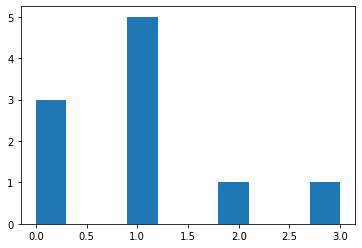

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

### 8. Plot multiple model runs

You’ll should see something like the distribution above. Yours will almost certainly look at least slightly different, since each run of the model is random, after all.

To get a better idea of how a model behaves, we can create multiple model runs and see the distribution that emerges from all of them. We can do this with a nested for loop:

(array([431., 297., 165.,  69.,  26.,  12.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

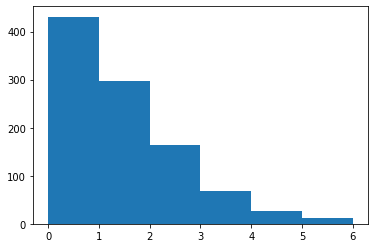

In [8]:
all_wealth = []
#This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

### 9. Adding Space for in model class

Many ABMs have a spatial element, with agents moving around and interacting with nearby neighbors. Mesa currently supports two overall kinds of spaces: grid, and continuous. Grids are divided into cells, and agents can only be on a particular cell, like pieces on a chess board. Continuous space, in contrast, allows agents to have any arbitrary position. Both grids and continuous spaces are frequently toroidal, meaning that the edges wrap around, with cells on the right edge connected to those on the left edge, and the top to the bottom. This prevents some cells having fewer neighbors than others, or agents being able to go off the edge of the environment.

Let’s add a simple spatial element to our model by putting our agents on a grid and make them walk around at random. Instead of giving their unit of money to any random agent, they’ll give it to an agent on the same cell.

Mesa has two main types of grids: SingleGrid and MultiGrid. SingleGrid enforces at most one agent per cell; MultiGrid allows multiple agents to be in the same cell. Since we want agents to be able to share a cell, we use MultiGrid.



In [9]:
from mesa.space import MultiGrid

We instantiate a grid with width and height parameters, and a boolean as to whether the grid is toroidal. Let’s make width and height model parameters, in addition to the number of agents, and have the grid always be toroidal. We can place agents on a grid with the grid’s place_agent method, which takes an agent and an (x, y) tuple of the coordinates to place the agent.

In [10]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

### 10. Making agents move in the space using agent class

Under the hood, each agent’s position is stored in two ways: the agent is contained in the grid in the cell it is currently in, and the agent has a pos variable with an (x, y) coordinate tuple. The place_agent method adds the coordinate to the agent automatically.

Now we need to add to the agents’ behaviors, letting them move around and only give money to other agents in the same cell.

First let’s handle movement, and have the agents move to a neighboring cell. The grid object provides a move_agent method, which like you’d imagine, moves an agent to a given cell. 

There’s an even simpler way, using the grid’s built-in get_neighborhood method, which returns all the neighbors of a given cell. This method can get two types of cell neighborhoods: Moore (includes all 8 surrounding squares), and Von Neumann(only up/down/left/right). It also needs an argument as to whether to include the center cell itself as one of the neighbors.

Next, we need to get all the other agents present in a cell, and give one of them some money. We can get the contents of one or more cells using the grid’s get_cell_list_contents method, or by accessing a cell directly. The method accepts a list of cell coordinate tuples, or a single tuple if we only care about one cell.

In [11]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


### 11. Consolidate agent class and model class in this section, create a model with 50 agents on a 10x10 grid, and run it for 20 steps

In [12]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [13]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

### 12. Plot grid objects

Now let’s use matplotlib and numpy to visualize the number of agents residing in each cell. To do that, we create a numpy array of the same size as the grid, filled with zeros. Then we use the grid object’s coord_iter() feature, which lets us loop over every cell in the grid, giving us each cell’s coordinates and contents in turn.

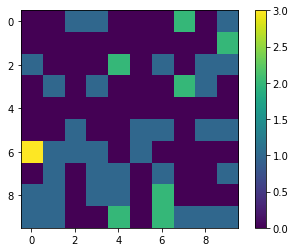

In [14]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()


# B. Analysis

### 1. Collecting Data

So far, at the end of every model run, we’ve had to go and write our own code to get the data out of the model. This has two problems: it isn’t very efficient, and it only gives us end results. If we wanted to know the wealth of each agent at each step, we’d have to add that to the loop of executing steps, and figure out some way to store the data.

Since one of the main goals of agent-based modeling is generating data for analysis, Mesa provides a class which can handle data collection and storage for us and make it easier to analyze.

The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s collect method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s unique_id.

Let’s add a DataCollector to the model, and collect two variables. At the agent level, we want to collect every agent’s wealth at every step. At the model level, let’s measure the model’s Gini Coefficient, a measure of wealth inequality.

In [15]:
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

At every step of the model, the datacollector will collect and store the model-level current Gini coefficient, as well as each agent’s wealth, associating each with the current step.

We run the model just as we did above. Now is when an interactive session, especially via a Notebook, comes in handy: the DataCollector can export the data it’s collected as a pandas DataFrame, for easy interactive analysis.

In [16]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

### 2. Get a series of Gini's co-efficient

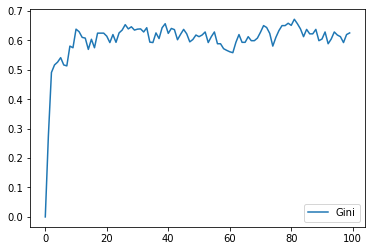

In [17]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

### 3. Print agent wealth data

In [18]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

### 4. Plot histogram for agent wealth

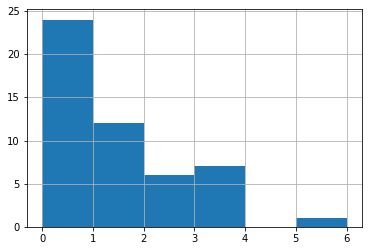

In [19]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

### 5. Plot wealth of one agent

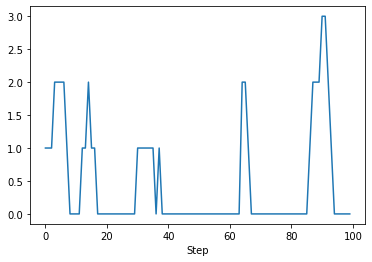

In [20]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

### 6. Batchrun

Like we mentioned above, you usually won’t run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model’s outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a BatchRunner class which automates it for you.

The BatchRunner also requires an additional variable self.running for the MoneyModel class. This variable enables conditional shut off of the model once a condition is met. In this example it will be set as True indefinitely.

In [21]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

We instantiate a BatchRunner with a model class to run, and two dictionaries: one of the fixed parameters (mapping model arguments to values) and one of varying parameters (mapping each parameter name to a sequence of values for it to take). The BatchRunner also takes an argument for how many model instantiations to create and run at each combination of parameter values, and how many steps to run each instantiation for. Finally, like the DataCollector, it takes dictionaries of model- and agent-level reporters to collect. Unlike the DataCollector, it won’t collect the data every step of the model, but only at the end of each run.

In the following example, we hold the height and width fixed, and vary the number of agents. We tell the BatchRunner to run 5 instantiations of the model with each number of agents, and to run each for 100 steps.*

We have it collect the final Gini coefficient value.

Now, we can set up and run the BatchRunner:

The total number of runs is 245. That is 10 agents to 490 increasing by 10, making 49 agents populations. Each agent population is then run 5 times (49 5) for 245 iterations

In [22]:
from mesa.batchrunner import BatchRunner

In [23]:
fixed_params = {"width": 10,
               "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

245it [02:56,  1.39it/s]


### 7. Pass model collection via BatchRunner

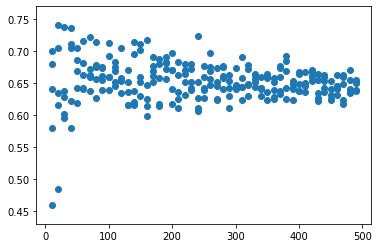

In [24]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)

Notice that each row is a model run, and gives us the parameter values associated with that run. We can use this data to view a scatter-plot comparing the number of agents to the final Gini.

### 8. Call the datacollector from the model via BatchRunner

Second, BatchRunner can call the datacollector from the model. The output is a dictionary, where each key is the parameters with the iteration number and then the datacollector dataframe. So in this model (<#number of agents>, <iteration#>).

In [25]:
#Get the Agent DataCollection
data_collector_agents = batch_run.get_collector_agents()

data_collector_agents[(10,2)]

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
99   5             0
     6             2
     7             0
     8             0
     9             1

[1000 rows x 1 columns]

In [26]:
#Get the Model DataCollection.

data_collector_model = batch_run.get_collector_model()

data_collector_model[(10,1)]

,Gini
0,0.00
1,0.18
2,0.18
3,0.32
4,0.42
...,...
95,0.58
96,0.58
97,0.58
98,0.54


# C. Visualization

So far, we’ve built a model, run it, and analyzed some output afterwards. However, one of the advantages of agent-based models is that we can often watch them run step by step, potentially spotting unexpected patterns, behaviors or bugs, or developing new intuitions, hypotheses, or insights. Other times, watching a model run can explain it to an unfamiliar audience better than static explanations. Like many ABM frameworks, Mesa allows you to create an interactive visualization of the model. In this section we’ll walk through creating a visualization using built-in components, and (for advanced users) how to create a new visualization element.

First, a quick explanation of how Mesa’s interactive visualization works. Visualization is done in a browser window, using JavaScript to draw the different things being visualized at each step of the model. To do this, Mesa launches a small web server, which runs the model, turns each step into a JSON object (essentially, structured plain text) and sends those steps to the browser.

A visualization is built up of a few different modules: for example, a module for drawing agents on a grid, and another one for drawing a chart of some variable. Each module has a Python part, which runs on the server and turns a model state into JSON data; and a JavaScript side, which takes that JSON data and draws it in the browser window. Mesa comes with a few modules built in, and let you add your own as well.

### 1. Grid Visualization

To start with, let’s have a visualization where we can watch the agents moving around the grid. Import the server class and the Canvas Grid class (so-called because it uses HTML5 canvas to draw a grid).

In [27]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


CanvasGrid works by looping over every cell in a grid, and generating a portrayal for every agent it finds. A portrayal is a dictionary (which can easily be turned into a JSON object) which tells the JavaScript side how to draw it. The only thing we need to provide is a function which takes an agent, and returns a portrayal object. Here’s the simplest one: it’ll draw each agent as a red, filled circle which fills half of each cell.

### 2. Agent Potrayal

In [28]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Color": "red",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    return portrayal

In addition to the portrayal method, we instantiate a canvas grid with its width and height in cells, and in pixels. In this case, let’s create a 10x10 grid, drawn in 500 x 500 pixels.

In [29]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

### 3. Launch visualization server

Now we create and launch the actual server. We do this with the following arguments:

The model class we’re running and visualizing; in this case, MoneyModel.

A list of module objects to include in the visualization; here, just [grid]

The title of the model: “Money Model”

Any inputs or arguments for the model itself. In this case, 100 agents, and height and width of 10.

Once we create the server, we set the port for it to listen on (you can treat this as just a piece of the URL you’ll open in the browser). Finally, when you’re ready to run the visualization, use the server’s launch() method.

In [30]:
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
#server.port = 8521 # The default
#server.launch()

The full code should now look like:

In [31]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

#server.port = 8521 # The default
#server.launch()

Now run this file; this should launch the interactive visualization server and open your web browser automatically. (If the browser doesn’t open automatically, try pointing it at http://127.0.0.1:8521 manually. If this doesn’t show you the visualization, something may have gone wrong with the server launch.)



Click ‘step’ to advance the model by one step, and the agents will move around. Click ‘run’ and the agents will keep moving around, at the rate set by the ‘fps’ (frames per second) slider at the top. Try moving it around and see how the speed of the model changes. Pressing ‘pause’ will (as you’d expect) pause the model; presing ‘run’ again will restart it. Finally, ‘reset’ will start a new instantiation of the model.

To stop the visualization server, go back to the terminal where you launched it, and press Control+c.

### 4. Changing agents

In the visualization above, all we could see is the agents moving around – but not how much money they had, or anything else of interest. Let’s change it so that agents who are broke (wealth 0) are drawn in grey, smaller, and above agents who still have money.

To do this, we go back to our agent_portrayal code and add some code to change the portrayal based on the agent properties.

In [32]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

Now launch the server again - this will open a new browser window pointed at the updated visualization. Initially it looks the same, but advance the model and smaller grey circles start to appear. Note that since the zero-wealth agents have a higher layer number, they are drawn on top of the red agents.



In [33]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
#server.port = 8521 # The default
#server.launch()

### 5. Adding a chart

Next, let’s add another element to the visualization: a chart, tracking the model’s Gini Coefficient. This is another built-in element that Mesa provides.

In [34]:
from mesa.visualization.modules import ChartModule

The basic chart pulls data from the model’s DataCollector, and draws it as a line graph using the Charts.js JavaScript libraries. We instantiate a chart element with a list of series for the chart to track. Each series is defined in a dictionary, and has a Label (which must match the name of a model-level variable collected by the DataCollector) and a Color name. We can also give the chart the name of the DataCollector object in the model.

Finally, we add the chart to the list of elements in the server. The elements are added to the visualization in the order they appear, so the chart will appear underneath the grid.



In [35]:
chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

Launch the visualization and start a model run, and you’ll see a line chart underneath the grid. Every step of the model, the line chart updates along with the grid. Reset the model, and the chart resets too.



In [36]:
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step

Note: You might notice that the chart line only starts after a couple of steps; this is due to a bug in Charts.js which will hopefully be fixed soon.